In [2]:
# Unzip the folder
import zipfile
zip_ref= zipfile.ZipFile('/content/images_compressed.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
#!pip install tensorflow numpy scikit-learn matplotlib

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity


In [4]:
# Load VGG16 without top layer (no classifier)
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# Build embedding model
embedding_model = Sequential([
    conv_base,
    Flatten(),
    Dense(256, activation='relu')  # output 256-d embedding
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
store_dir = "/content/images_compressed"
store_embeddings = []
store_image_paths = []

#check for image only
valid_extensions = ('.jpg', '.jpeg', '.png')
store_image_paths = [os.path.join(store_dir, f)
                  for f in os.listdir(store_dir)
                  if f.lower().endswith(valid_extensions)]


#check corrupt image
from PIL import Image

valid_paths = []
for path in store_image_paths:
    try:
        img = Image.open(path)
        img.verify()  # check if image is readable
        valid_paths.append(path)
    except:
        print("Skipping corrupted image:", path)

store_image_paths = valid_paths

#Creating embedding vector for image of my data base
for img_path in store_image_paths:
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(150,150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # normalize

    # Get embedding
    emb = embedding_model.predict(img_array, verbose=0)
    store_embeddings.append(emb[0])  # flatten to 1D

store_embeddings = np.array(store_embeddings)
print("Store embeddings shape:", store_embeddings.shape)


Skipping corrupted image: /content/images_compressed/b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg
Skipping corrupted image: /content/images_compressed/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg
Skipping corrupted image: /content/images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg
Skipping corrupted image: /content/images_compressed/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg
Skipping corrupted image: /content/images_compressed/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg
Skipping corrupted image: /content/images_compressed/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg
Store embeddings shape: (5756, 256)


In [6]:
def get_top5_similar(query_path, store_embeddings, store_image_paths):
    # Load and preprocess query image
    img = image.load_img(query_path, target_size=(150,150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get query embedding
    query_emb = embedding_model.predict(img_array, verbose=0)

    # Compute cosine similarity
    sims = cosine_similarity(query_emb, store_embeddings)[0]

    # Get top 5 indices
    top5_idx = sims.argsort()[-5:][::-1]
    top5_paths = [store_image_paths[i] for i in top5_idx]
    top5_scores = sims[top5_idx]

    return top5_paths, top5_scores


In [7]:
def show_recommendations(query_path, top5_paths, top5_scores):
    plt.figure(figsize=(15,5))

    # Show query image
    plt.subplot(1,6,1)
    query_img = image.load_img(query_path, target_size=(150,150))
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis('off')

    # Show top-5 similar images
    for i, (path, score) in enumerate(zip(top5_paths, top5_scores)):
        plt.subplot(1,6,i+2)
        sim_img = image.load_img(path, target_size=(150,150))
        plt.imshow(sim_img)
        plt.title(f"{score:.2f}")
        plt.axis('off')
    plt.show()


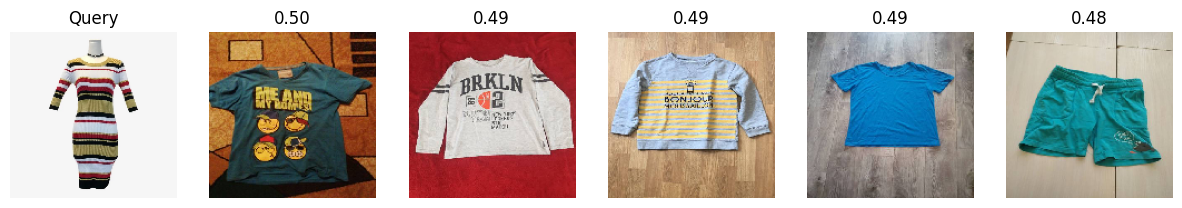

In [10]:
query_image = "/content/query7.jpg"  # user uploaded photo

top5_paths, top5_scores = get_top5_similar(query_image, store_embeddings, store_image_paths)
show_recommendations(query_image, top5_paths, top5_scores)


In [11]:
import numpy as np

# Save embeddings and corresponding image paths
np.save("store_embeddings.npy", store_embeddings)
np.save("store_image_paths.npy", np.array(store_image_paths))
